In [19]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import gc
!nvidia-smi

Wed Aug  3 13:59:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.77       Driver Version: 512.77       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
|  0%   42C    P8    11W / 184W |  11183MiB / 12288MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 設定訓練及測試資料集和訓練參數

In [20]:
BIT_COUNT = 16
iterations = 7  #攻擊次數
alpha = 0.0001  #攻擊程度
epsilon = 8.0 / 255  #攻擊範圍
EPOCH = 50 #訓練EPOCH

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train[:1500]
y_train = y_train[:1500]
x_test = x_test[:1500]

image_shape = (28, 28, 1)
x_train = x_train.reshape((-1,) + image_shape)
x_test = x_test.reshape((-1,) + image_shape)

## 設定資料擴增

In [21]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomRotation(0.02, fill_mode = 'constant'),
    RandomZoom(.2, .2)
])

## 設定訓練模型

In [22]:
adam = Adam(learning_rate=0.0002, beta_1=0.5)

In [23]:
inputs = Input((28, 28, 1))
x = Conv2D(64, (3, 3), padding="same", activation='relu')(inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding="same", activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding="same", activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(BIT_COUNT+1, activation="softmax")(x)
decoder = Model(inputs=inputs, outputs=x)
decoder.compile(optimizer=adam, loss='binary_crossentropy', metrics=['categorical_accuracy'])
decoder.summary()
from keras.utils.vis_utils import plot_model
plot_model(decoder, to_file='model.png', show_shapes=True,show_layer_names=False)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 16)          4624

In [24]:

#利用pgd的idea修改圖片 讓它生出我想要的label
def pgd_attack_to_target(input_image, target_label, loss_object, model, epsilon, alpha, iterations):
    x_adv = input_image  # 複製一個圖片 (不要動到原圖片)
    for i in range(iterations):  # 做很多次
        x_adv = tf.convert_to_tensor(x_adv)  # 將圖片轉成tensor
        with tf.GradientTape() as tape:  #開始計算梯度
            tape.watch(x_adv)  # 要計算的圖片是x_adv
            prediction = model(x_adv)  #先做判斷(取得目前的結果)
            loss = loss_object(target_label, prediction)  # 計算loss(距離target有多遠)
        grad = tape.gradient(loss, x_adv)  # 計算梯度 (loss對x_adv的梯度，d_loss/d_x_adv)
        x_adv_new  = x_adv - alpha * tf.sign(grad)  # 更新圖片(做梯度下降會讓預測結果接近我想要的label)
        x_adv = tf.clip_by_value(x_adv_new , x_adv - epsilon, x_adv + epsilon)  # 限制圖片的範圍
        x_adv = tf.clip_by_value(x_adv, 0, 1)  # 限制圖片的範圍(圖片要在0~1之間)
        x_adv = x_adv.numpy()  # 將圖片轉成numpy
    return x_adv  # 回傳攻擊後的圖片

In [25]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    dec_loss = losses["decoder"]

    plt.figure(figsize=(10, 8))
    plt.plot(dec_loss, label="decoder loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [26]:
list = np.array([ i for i in range(BIT_COUNT+1)])
user_code = np.eye(BIT_COUNT+1)[list]
print(user_code)  #生成onehot encoding

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


## 訓練模型

In [27]:

DATA_LENGTH = len(x_train)

# x_train_adv[0]是沒有攻擊的圖片
x_train_adv = [x_train.copy() for _ in range(BIT_COUNT+1)]

losses = {"decoder": []}

#開始訓練
for epoch in range(EPOCH):

    ##第一步 調整圖片 讓decoder能正確讀取出user_code
    for i in range(1, BIT_COUNT+1):
        x_train_adv[i] = pgd_attack_to_target(x_train_adv[i], [user_code[i]] * DATA_LENGTH,
                                              tf.keras.losses.CategoricalCrossentropy(), decoder, epsilon,
                                              alpha, iterations)

    ##第二步 data augmentation(旋轉，縮放....)
    x_train_adv_att = [data_augmentation(x_train_adv[i]) for i in range(BIT_COUNT+1)]

    #第四步 訓練Decoder
    decoder_x = np.concatenate((np.concatenate([x_train_adv[i] for i in range(BIT_COUNT+1)]),
                                np.concatenate([x_train_adv_att[i] for i in range(BIT_COUNT+1)])))
    decoder_y = np.concatenate((np.concatenate([[user_code[i]] * DATA_LENGTH for i in range(BIT_COUNT+1)]),
                                np.concatenate([[user_code[i]] * DATA_LENGTH for i in range(BIT_COUNT+1)])))

    decoder_loss = decoder.fit(decoder_x, decoder_y, epochs=1)

    #紀錄loss
    # losses["discriminator"].append(discriminator_loss.history["loss"])
    losses["decoder"].append(decoder_loss.history["loss"])
    print("epoch:{}  decoder_loss:{}".format(epoch, decoder_loss.history["loss"]))
    del decoder_x
    del decoder_y
    del x_train_adv_att
    gc.collect()




1594/1594 [==============================] - 15s 9ms/step - loss: 0.2302 - categorical_accuracy: 0.0578
epoch:0  decoder_loss:[0.2302020937204361]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2243 - categorical_accuracy: 0.0596
epoch:1  decoder_loss:[0.22427910566329956]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2242 - categorical_accuracy: 0.0575
epoch:2  decoder_loss:[0.2241765409708023]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2241 - categorical_accuracy: 0.0569
epoch:3  decoder_loss:[0.22413481771945953]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2241 - categorical_accuracy: 0.0586
epoch:4  decoder_loss:[0.22407054901123047]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.2240 - categorical_accuracy: 0.0596
epoch:5  decoder_loss:[0.22400891780853271]
1594/1594 [==============================] - 14s 9ms/step - loss: 0.1182 - categorical_accuracy: 0.5553
epoch:6  d

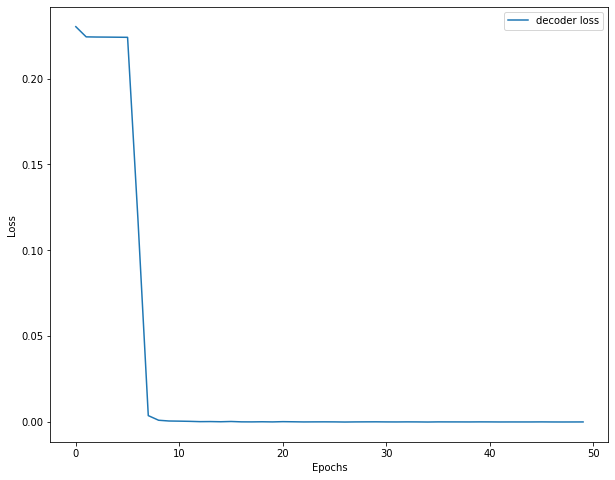

In [28]:
plot_loss(losses)